# Group 10 - First Year Project
### Data Science at ITU 
## Project 2 - Correlation between Covid-19's spread and weather conditions

Introduction

This notebook contains all the code developed in the Project 2 - Correlation between Covid-19's spread and weather conditions

Contact/Group: 
- Florian Micliuc(flmi@itu.dk)
- Louis Caspar Brandt (locb@itu.dk) (see disclosure statement in the report)
- Iben Mai Huse (ibhu@itu.dk)
- Katalin Literati-Dobos (klit@itu.dk)
- Ruben Jonsman (rubj@itu.dk)

# Library imports

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import math
from collections import Counter
from scipy.stats import chi2_contingency
import seaborn as sns
import folium
from folium import plugins 
from folium.plugins import HeatMap, MarkerCluster
import shapely
import json 
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon, MultiPolygon
import branca
import branca.colormap as cm
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from folium.features import DivIcon
import imageio
from matplotlib import rcParams
import calplot

# Functions

In [2]:
def check_null_values(file, string):
    if file.isnull().values.any():
        print('There are null values in {} dataset'.format(string))
    else:
        print('There are no null values in {} dataset'.format(string))

In [3]:
def dataset_checker_values(dataset,value):
    SA = dataset.copy()
    SA.replace(value, np.nan, inplace=True)
    missingdata_df = SA.columns[SA.isnull().any()].tolist()
    msno.matrix(SA);

In [4]:
def weather_mean_bar_plot(column,df):
    list_month = ['February','March','April','May','June','July','August','September','October','November','December','January','February']
    fig,ax = plt.subplots(figsize = (16,4))
    df[column].plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
    ax.set_title('Mean of' + ' '+ column)
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')
    ax.set_xticklabels(list_month)

In [5]:
def corona_total_bar_plot(column,df):
    list_month = ['February','March','April','May','June','July','August','September','October','November','December','January','February']
    fig,ax = plt.subplots(figsize = (16,4))
    df[column].plot.bar(color = 'silver',edgecolor = 'black',rot = 0)
    ax.set_title(column)
    ax.set_ylabel('Value')
    ax.set_xlabel('Month')
    ax.set_xticklabels(list_month)

In [6]:
def corona_line_plot(df,x,y,title):
    ax = df.plot.line(x = x, y = y,rot = 45,figsize = (20,6),color = 'silver')
    ax.set_title(title)
    ax.set_ylabel("Covid-19 Cases")
    ax.set_xlabel("Date")
    plt.axvline(x='2020-03-15',color = '#ff6c70',ls = '--');
    plt.axvline(x='2020-03-22',color = '#f00008',ls = '--');
    plt.axvline(x='2020-04-15',color = 'blue',ls = '--');
    plt.axvline(x='2020-11-02',color = '#ff6c70',ls = '--');
    plt.axvline(x='2020-12-15',color = '#f00008',ls = '--');
    plt.axvline(x='2020-12-26',color = '#00ff68',ls = '--');

In [7]:
def corona_bar_plot(x,y,title):
    fig = plt.figure(figsize=(20,6))
    axes = fig.add_axes([0,0,1,1])
    axes.bar(x, y,color = 'silver',edgecolor = 'black')
    axes.set_title(title)
    axes.set_ylabel("Covid-19 Cases")
    axes.set_xlabel("Date")

In [8]:
def pearson_association(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = pearsonr(df[column], df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [9]:
def spearman_association(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = spearmanr(df[column], df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [10]:
def pearson_log(df,column,headers,significance):
    corrs = []
    pvalues = []
    for var in headers:
        corr, pvalue = pearsonr(np.log(df[column]), df[var])
        print(var,'\n',round(corr,5),'   ',pvalue,pvalue<significance,'\n')

In [11]:
def heat_calendar(df,column,color,title):
    calplot.calplot(df[column], cmap=color,colorbar = True,figsize = (16,4),suptitle=title)

# Task 0 - Data cleaning and filtering

## Loading data

The data was loaded by creating a small pipeline to keep track of files and locations, in case they would change. This approach made it easy to change file locations if needed.

In [12]:
PATH = {}
PATH["data_raw"] = "../data/raw/"
PATH["data_interim"] = "../data/interim/"
PATH["data_processed"] = "../data/processed/"
PATH["data_external"] = "../data/external/"

SUBPATH = {}
SUBPATH["corona"] = "corona/"
SUBPATH["meta"] = "metadata/"
SUBPATH["shape"] = "shapefiles/"
SUBPATH["weather"] = "weather/"
SUBPATH["age"] = "age/"

FILENAME = {}
FILENAME["corona"] = "de_corona.csv"
FILENAME["meta"] = "de_metadata.json"
FILENAME["shape"] = "de.geojson"
FILENAME["weather"] = "weather.csv"
FILENAME["age_pop"] = "Altersverteilung_Bevolkerung.csv"

corona = PATH["data_raw"]+SUBPATH["corona"]+FILENAME["corona"]
meta = PATH["data_raw"]+SUBPATH["meta"]+FILENAME["meta"]
shape = PATH["data_raw"]+SUBPATH["shape"]+FILENAME["shape"]
weather = PATH["data_raw"]+SUBPATH["weather"]+FILENAME["weather"]
age_pop = PATH["data_external"]+SUBPATH["age"]+FILENAME["age_pop"]

The dates is parsed in the data, so that it has a consistent form. The data is tab seperated and thus we load the data with a tab seperator. We also append the extra data that was provided to our original weather data frame.

In [13]:
raw_data = {}

from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

#data
raw_data['de_corona'] = pd.read_csv(corona, sep='\t', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = pd.read_csv(weather, sep='\t', parse_dates=['date'], date_parser=dateparse)
additional = pd.read_csv('../Data/Raw/weather/weather2.csv', sep='\t', parse_dates=['date'], date_parser=dateparse)
raw_data['weather'] = raw_data['weather'].append(additional)

#open jsonfile_metadata
with open(meta, 'r', encoding='utf-8') as f:
    country_metadata = json.loads(f.read())

#task4
raw_data['age_pop'] = pd.read_csv(age_pop, sep=';', decimal=',')

In [14]:
HEADERS = ['de_corona','weather']
for i in HEADERS:
    print(i +"  \tDataFrame shape: " + str(raw_data[i].shape))

de_corona  	DataFrame shape: (5602, 4)
weather  	DataFrame shape: (20220, 9)


## Data type insight

With the data provided involved the following fields: 

In [15]:
list(raw_data["weather"].columns), list(raw_data["de_corona"].columns)

(['date',
  'iso3166-2',
  'RelativeHumiditySurface',
  'SolarRadiation',
  'Surfacepressure',
  'TemperatureAboveGround',
  'Totalprecipitation',
  'UVIndex',
  'WindSpeed'],
 ['date', 'region_code', 'confirmed_addition', 'deceased_addition'])

The following fields are categorical variables:
- iso3166-2 (the codes of the regions in Germany)
- date
- region_code (the name of the region)

The following fields are numerical variables:
- RelativeHumiditySurface 
- SolarRadiation (measured j/sqm)
- Surfacepressure 
- TemperatureAboveGround (measured in Kelvin)
- Totalprecipitation
- UVIndex (1-10)
- Windspeed (m/s)
- confirmed_addition (number of confirmed Covid-19 infections)
- deceased_addition (number of deceased with a confirmed Covid-19 infections)

All the weather data is a 24-hour sum of the day, which will result in higher than expected values, these variables can be divided by 24 to get the mean of the day, though this will also be flawed data, since the data will have a daily mean. SolarRadiation, UVIndex is only relevent when the sun is actually present during the day, by getting the daily mean, the hours of the day where the sun is not active is taken into account, which results in lower than expected values. 

## Filtering the weather dataset

Our assigned country in this project is Germany and thus we filter the data so that we only have data from Germany

In [16]:
#get Germany data
weather_data_de = raw_data["weather"][raw_data["weather"]["iso3166-2"].str.startswith("DE")]
#reset_index
weather_data_de.reset_index(drop=True, inplace=True)

#Processed data
processed_data = {}
processed_data["weather"] = weather_data_de
processed_data["weather"].to_csv("../Data/Processed/processed_weather.csv")
processed_data["de_corona"] = raw_data["de_corona"]

## Sanity check

Here we check for typical issues with raw data. We are checking for missing data, duplicate data and null values.

### Check for null values

In [17]:
check_null_values(raw_data['de_corona'], "de_corona")
check_null_values(weather_data_de, "weather_data_de")

There are no null values in de_corona dataset
There are no null values in weather_data_de dataset


### Checking if our data source corrected their data by adding negative values to the previous day, to get the cummulitative sum correct

In [18]:
print('min deaths',min(raw_data['de_corona']['deceased_addition']))
print('min cases',min(raw_data['de_corona']['confirmed_addition']))

min deaths 0
min cases 1


### Checking and visualizing for weird values

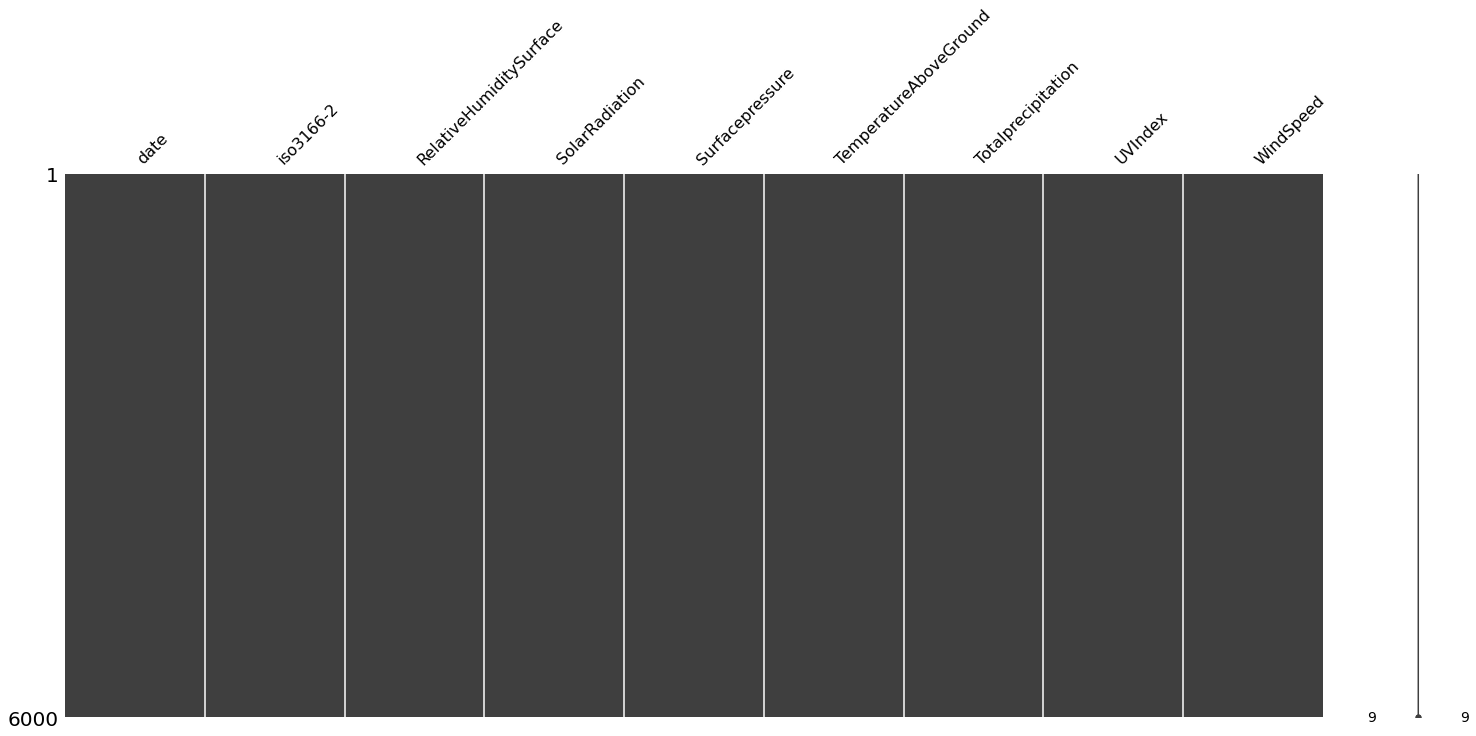

In [19]:
dataset_checker_values(weather_data_de,-999) #-999

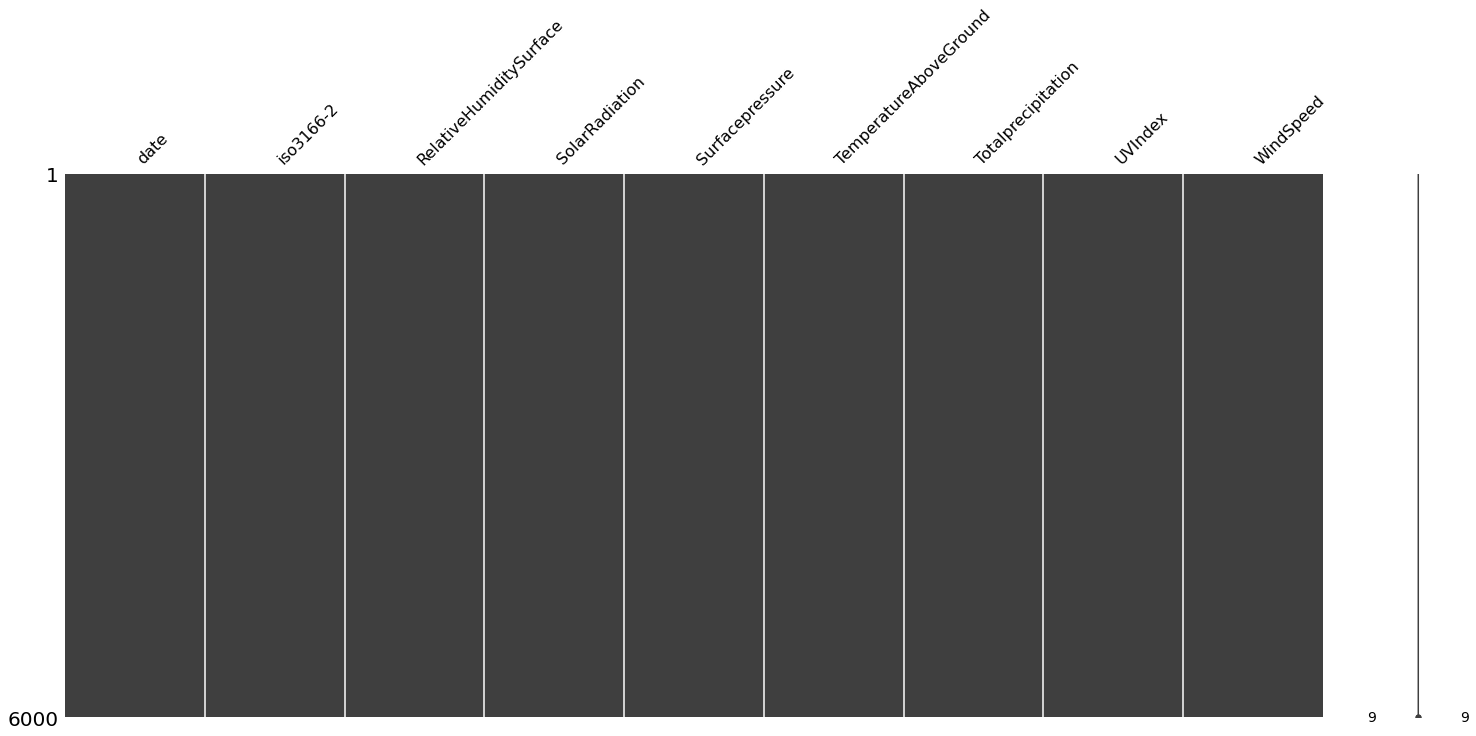

In [20]:
dataset_checker_values(weather_data_de,-1) #-1

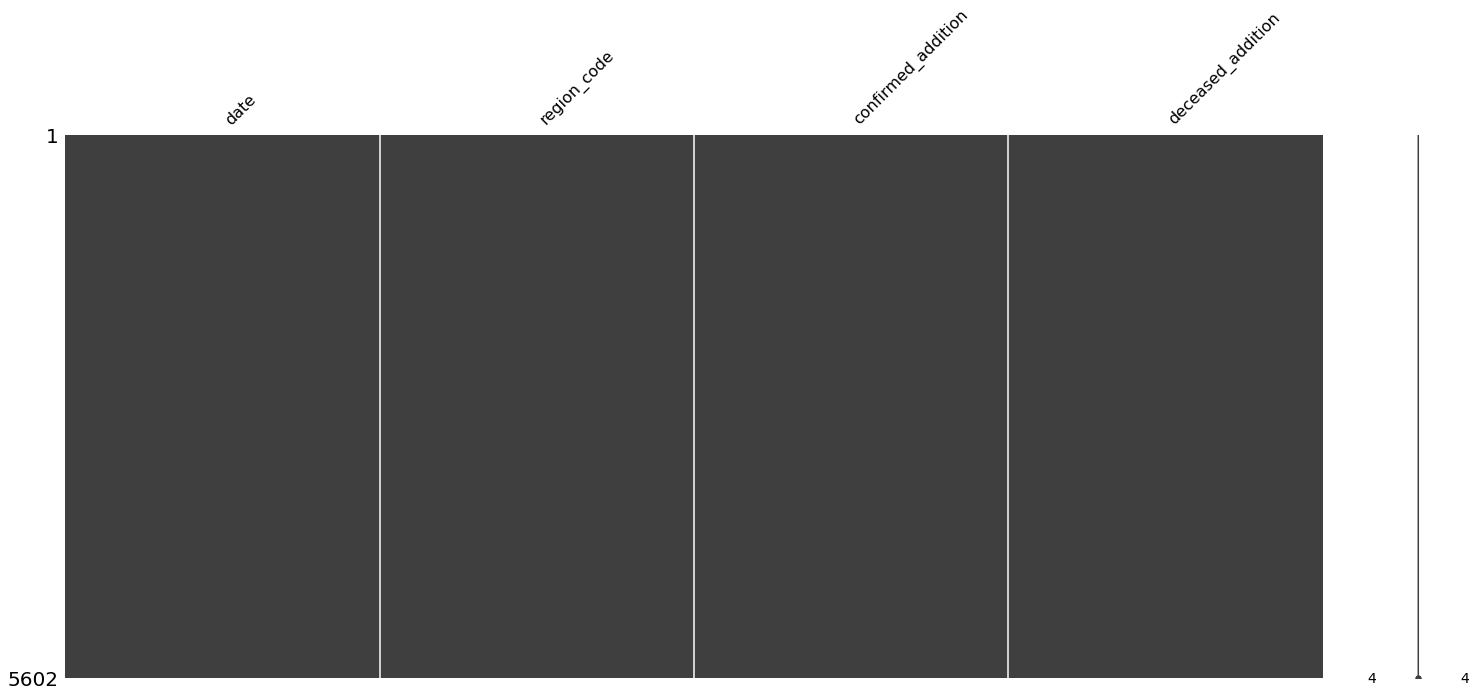

In [21]:
dataset_checker_values(raw_data['de_corona'],-999) #-999

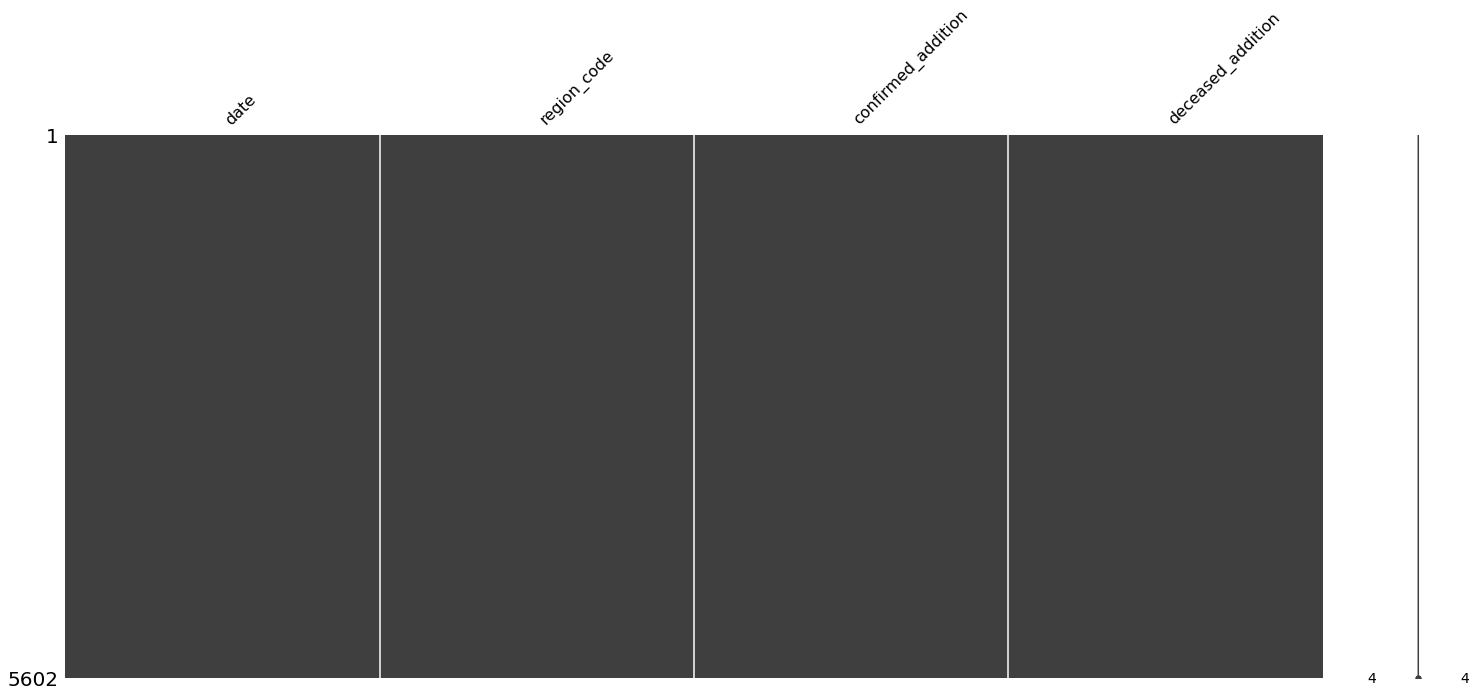

In [22]:
dataset_checker_values(raw_data['de_corona'],-1) #-1

### Checking for duplicates

In [23]:
if True in list(raw_data["de_corona"].duplicated()):
    print("Duplicate rows")
else: 
    print("No duplicate rows")

No duplicate rows


## Data Manipulation

In [24]:
#adding the region to the de_corona df
corona_df = raw_data['de_corona']
ss = dict()
for i in country_metadata['country_metadata']:
    ss[i['covid_region_code']] = i['iso3166-2_code']
corona_df['region'] = corona_df['region_code'].map(ss)
corona_df

,date,region_code,confirmed_addition,deceased_addition,region
0,2020-01-02,Nordrhein-Westfalen,1,0,DE-NW
1,2020-01-07,Nordrhein-Westfalen,1,0,DE-NW
2,2020-01-09,Nordrhein-Westfalen,1,1,DE-NW
3,2020-01-12,Nordrhein-Westfalen,1,0,DE-NW
4,2020-01-14,Nordrhein-Westfalen,1,0,DE-NW
...,...,...,...,...,...
5597,2021-02-21,Rheinland-Pfalz,120,0,DE-RP
5598,2021-02-21,Sachsen,68,0,DE-SN
5599,2021-02-21,Sachsen-Anhalt,84,0,DE-ST
5600,2021-02-21,Schleswig-Holstein,113,0,DE-SH


In [25]:
celsius = pd.DataFrame(weather_data_de['TemperatureAboveGround'].subtract(273.15))
weather_data_de['Temp_Celsius'] = celsius
weather_data_de

<ipython-input-25-8b0f84d71407>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data_de['Temp_Celsius'] = celsius


,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,Temp_Celsius
0,2020-02-13,DE-BB,76.337444,1.824290e+06,2.403341e+06,276.551573,0.003355,2.777806,4.542822,3.401573
1,2020-02-13,DE-BE,76.065297,1.786373e+06,2.408182e+06,276.844633,0.003523,4.671329,4.761509,3.694633
2,2020-02-13,DE-BW,80.113988,1.505760e+06,2.290158e+06,276.227143,0.008013,4.268546,4.467024,3.077143
3,2020-02-13,DE-BY,81.554346,2.363013e+06,2.275361e+06,275.583053,0.005227,4.417797,3.677414,2.433053
4,2020-02-13,DE-HB,87.167414,8.389756e+03,2.406940e+06,276.237452,0.007715,1.794872,4.699573,3.087452
...,...,...,...,...,...,...,...,...,...,...
5995,2021-02-21,DE-SH,78.077610,5.698494e+06,2.431487e+06,281.943486,0.000000,4.474084,2.532838,8.793486
5996,2021-02-21,DE-SL,60.483775,8.762859e+06,2.350492e+06,283.516066,0.000000,8.000000,3.247090,10.366066
5997,2021-02-21,DE-SN,74.638170,6.687276e+06,2.363996e+06,279.277820,0.000008,5.409593,4.648033,6.127820
5998,2021-02-21,DE-ST,69.587170,7.276057e+06,2.408002e+06,282.418775,0.000000,5.273630,2.972845,9.268775


In [26]:
#merging the corona dataset with the weather dataset for future associations. 
daily_corona_weather = corona_df.merge(weather_data_de, left_on = ["date", "region"], right_on = ["date", "iso3166-2"])
daily_corona_weather = daily_corona_weather.drop(["region_code", "region"], axis = 1)
daily_corona_weather #main

,date,confirmed_addition,deceased_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,Temp_Celsius
0,2020-02-16,1,0,DE-MV,69.818665,4.562424e+04,2.392858e+06,284.294049,0.004641,0.211216,7.888859,11.144049
1,2020-02-17,1,0,DE-BB,64.189273,9.007504e+05,2.409194e+06,282.312595,0.001005,2.631685,6.319781,9.162595
2,2020-02-18,1,0,DE-BB,71.904630,4.042940e+06,2.421421e+06,279.679468,0.002388,4.037911,6.150824,6.529468
3,2020-02-20,1,0,DE-NW,81.738535,1.064802e+06,2.383996e+06,279.663867,0.006802,3.524003,6.477330,6.513867
4,2020-02-24,1,0,DE-BW,80.314208,6.604918e+05,2.308155e+06,281.894530,0.005284,5.613589,4.663207,8.744530
...,...,...,...,...,...,...,...,...,...,...,...,...
5575,2021-02-21,120,0,DE-RP,65.642820,8.457394e+06,2.348996e+06,282.123657,0.000000,7.879810,3.009041,8.973657
5576,2021-02-21,68,0,DE-SN,74.638170,6.687276e+06,2.363996e+06,279.277820,0.000008,5.409593,4.648033,6.127820
5577,2021-02-21,84,0,DE-ST,69.587170,7.276057e+06,2.408002e+06,282.418775,0.000000,5.273630,2.972845,9.268775
5578,2021-02-21,113,0,DE-SH,78.077610,5.698494e+06,2.431487e+06,281.943486,0.000000,4.474084,2.532838,8.793486


# Numerical summary

There are 16 regions

In [27]:
list((raw_data['de_corona']['region_code']).unique())

['Nordrhein-Westfalen',
 'Berlin',
 'Saarland',
 'Bayern',
 'Niedersachsen',
 'Mecklenburg-Vorpommern',
 'Brandenburg',
 'Baden-Württemberg',
 'Hessen',
 'Rheinland-Pfalz',
 'Schleswig-Holstein',
 'Hamburg',
 'Bremen',
 'Sachsen',
 'Thüringen',
 'Sachsen-Anhalt']

### Daily registered cases in Germany

In [28]:
raw_data["de_corona"].describe()

,confirmed_addition,deceased_addition
count,5602.000000,5602.000000
mean,426.786862,12.121028
std,831.095886,25.823844
min,1.000000,0.000000
25%,18.000000,0.000000
50%,95.000000,1.000000
75%,396.000000,10.000000
max,6809.000000,213.000000


In [29]:
rcParams['figure.figsize'] = 25,4

C:\Users\flori\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


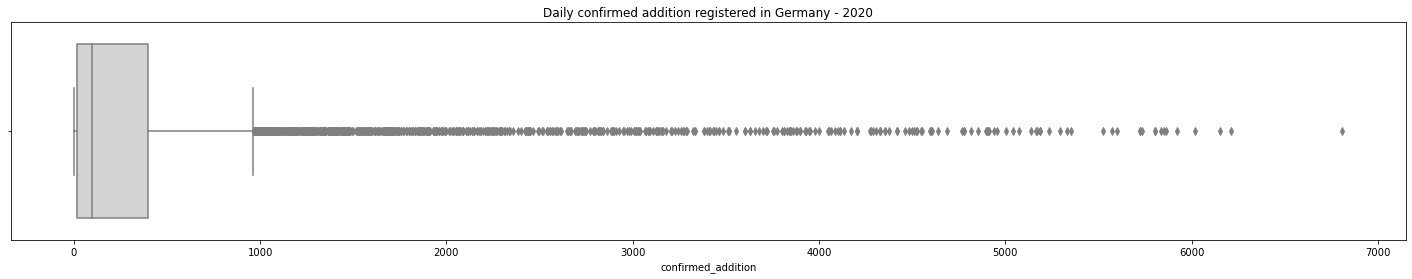

In [30]:
deCorona_confirmed = raw_data['de_corona']['confirmed_addition']
sns.boxplot(deCorona_confirmed, color='lightgray').set_title('Daily confirmed addition registered in Germany - 2020');

C:\Users\flori\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


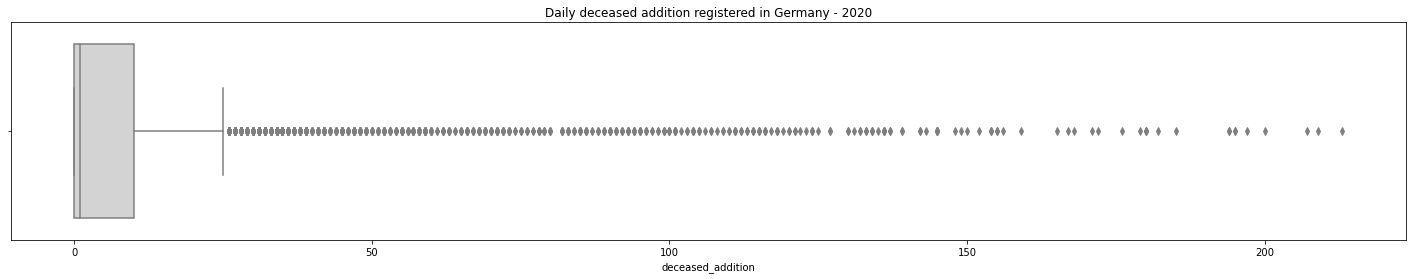

In [31]:
deCorona_deceased = raw_data['de_corona']['deceased_addition']
sns.boxplot(deCorona_deceased, color='lightgray').set_title('Daily deceased addition registered in Germany - 2020');

# Task 1 - Single Variable Analysis

## Corona

### Per Capita

In [32]:
#grouping the corona_dataset by region and adding the population

meta_df = pd.DataFrame(country_metadata['country_metadata'])
sorted_country_metadata = meta_df.sort_values(by = 'iso3166-2_name_en')
corona_by_region  = pd.DataFrame(raw_data['de_corona'].groupby(by = 'region_code').sum())
corona_by_region['iso3166-2_code'] = sorted_country_metadata['iso3166-2_code'].values
corona_by_region['population'] = sorted_country_metadata['population'].values

corona_by_region

,confirmed_addition,deceased_addition,iso3166-2_code,population
region_code,,,,
Baden-Württemberg,311152,7940,DE-BW,11069533
Bayern,428996,12123,DE-BY,13076721
Berlin,126896,2728,DE-BE,3644826
Brandenburg,74955,2914,DE-BB,2511917
Bremen,17485,327,DE-HB,682986
Hamburg,50291,1223,DE-HH,1841179
Hessen,184434,5672,DE-HE,6265809
Mecklenburg-Vorpommern,23436,692,DE-MV,1609675
Niedersachsen,159191,4104,DE-NI,7982448


In [33]:
#The number of cases by region/capita
corona_by_region['confirmed/pop'] = corona_by_region['confirmed_addition']/corona_by_region['population']
corona_by_region['deceased/pop'] = corona_by_region['deceased_addition']/corona_by_region['population']

In [34]:
corona_by_region.groupby("iso3166-2_code")["deceased/pop", "confirmed/pop"].describe()

<ipython-input-34-ae67f570d026>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  corona_by_region.groupby("iso3166-2_code")["deceased/pop", "confirmed/pop"].describe()


deceased/pop                                              \
                      count      mean std       min       25%       50%   
iso3166-2_code                                                            
DE-BB                   1.0  0.001160 NaN  0.001160  0.001160  0.001160   
DE-BE                   1.0  0.000748 NaN  0.000748  0.000748  0.000748   
DE-BW                   1.0  0.000717 NaN  0.000717  0.000717  0.000717   
DE-BY                   1.0  0.000927 NaN  0.000927  0.000927  0.000927   
DE-HB                   1.0  0.000479 NaN  0.000479  0.000479  0.000479   
DE-HE                   1.0  0.000905 NaN  0.000905  0.000905  0.000905   
DE-HH                   1.0  0.000664 NaN  0.000664  0.000664  0.000664   
DE-MV                   1.0  0.000430 NaN  0.000430  0.000430  0.000430   
DE-NI                   1.0  0.000514 NaN  0.000514  0.000514  0.000514   
DE-NW                   1.0  0.000704 NaN  0.000704  0.000704  0.000704   
DE-RP                   1.0  0.000733 NaN  0.000733  0.000733  0.000733   
DE-SH                   1.0  0.000418 NaN  0.000418  0.000418  0.000418   
DE-SL                   1.0  0.000856 NaN  0.000856  0.000856  0.000856   
DE-SN                   1.0  0.001829 NaN  0.001829  0.001829  0.001829   
DE-ST                   1.0  0.001038 NaN  0.001038  0.001038  0.001038   
DE-TH                   1.0  0.001279 NaN  0.001279  0.001279  0.001279   

                                   confirmed/pop                          \
                     75%       max         count      mean std       min   
iso3166-2_code                                                             
DE-BB           0.001160  0.001160           1.0  0.029840 NaN  0.029840   
DE-BE           0.000748  0.000748           1.0  0.034815 NaN  0.034815   
DE-BW           0.000717  0.000717           1.0  0.028109 NaN  0.028109   
DE-BY           0.000927  0.000927           1.0  0.032806 NaN  0.032806   
DE-HB           0.000479  0.000479           1.0  0.025601 NaN  0.025601   
DE-HE           0.000905  0.000905           1.0  0.029435 NaN  0.029435   
DE-HH           0.000664  0.000664           1.0  0.027315 NaN  0.027315   
DE-MV           0.000430  0.000430           1.0  0.014559 NaN  0.014559   
DE-NI           0.000514  0.000514           1.0  0.019943 NaN  0.019943   
DE-NW           0.000704  0.000704           1.0  0.029084 NaN  0.029084   
DE-RP           0.000733  0.000733           1.0  0.024510 NaN  0.024510   
DE-SH           0.000418  0.000418           1.0  0.014193 NaN  0.014193   
DE-SL           0.000856  0.000856           1.0  0.028325 NaN  0.028325   
DE-SN           0.001829  0.001829           1.0  0.046792 NaN  0.046792   
DE-ST           0.001038  0.001038           1.0  0.026570 NaN  0.026570   
DE-TH           0.001279  0.001279           1.0  0.034390 NaN  0.034390   

                                                        
                     25%       50%       75%       max  
iso3166-2_code                                          
DE-BB           0.029840  0.029840  0.029840  0.029840  
DE-BE           0.034815  0.034815  0.034815  0.034815  
DE-BW           0.028109  0.028109  0.028109  0.028109  
DE-BY           0.032806  0.032806  0.032806  0.032806  
DE-HB           0.025601  0.025601  0.025601  0.025601  
DE-HE           0.029435  0.029435  0.029435  0.029435  
DE-HH           0.027315  0.027315  0.027315  0.027315  
DE-MV           0.014559  0.014559  0.014559  0.014559  
DE-NI           0.019943  0.019943  0.019943  0.019943  
DE-NW           0.029084  0.029084  0.029084  0.029084  
DE-RP           0.024510  0.024510  0.024510  0.024510  
DE-SH           0.014193  0.014193  0.014193  0.014193  
DE-SL           0.028325  0.028325  0.028325  0.028325  
DE-SN           0.046792  0.046792  0.046792  0.046792  
DE-ST           0.026570  0.026570  0.026570  0.026570  
DE-TH           0.034390  0.034390  0.034390  0.034390

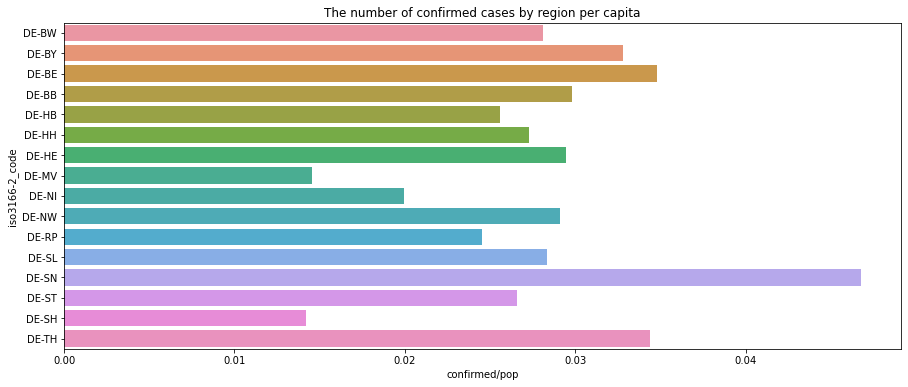

In [35]:
rcParams['figure.figsize'] = 15,6;
ax = sns.barplot(x="confirmed/pop", y="iso3166-2_code", data=corona_by_region).set_title('The number of confirmed cases by region per capita');

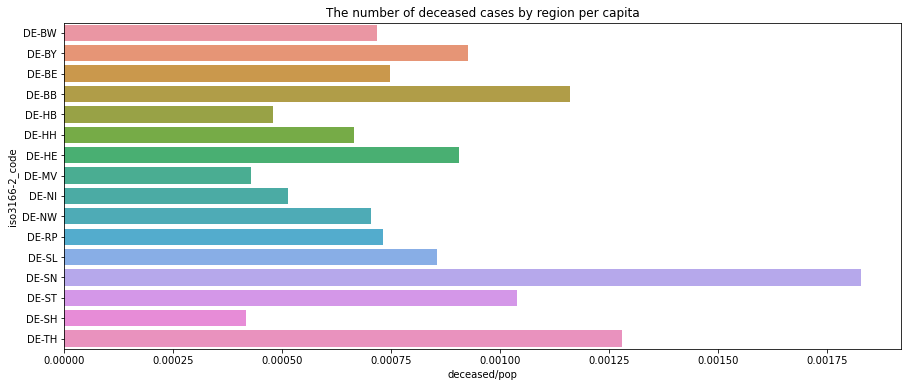

In [36]:
ax = sns.barplot(x="deceased/pop", y="iso3166-2_code", data=corona_by_region).set_title('The number of deceased cases by region per capita')

### Per Month

In [37]:
corona_date = pd.to_datetime(raw_data['de_corona']['date'])
corona_2020=pd.DataFrame(raw_data['de_corona'][corona_date.dt.year == 2020])
corona_2021=pd.DataFrame(raw_data['de_corona'][corona_date.dt.year == 2021])

corona_2021_month_sum = pd.DataFrame(corona_2021.groupby(corona_date.dt.month).sum())
corona_month_sum = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).sum())
corona_month_mean = pd.DataFrame(corona_2020.groupby(corona_date.dt.month).mean())
#corona_month_mean
right_one = corona_month_sum.append(corona_2021_month_sum)
right_one

,confirmed_addition,deceased_addition
date,,
1,18,1
2,121,0
3,73986,2682
4,88311,5713
5,19792,694
6,12926,146
7,15164,139
8,34485,116
9,49307,334


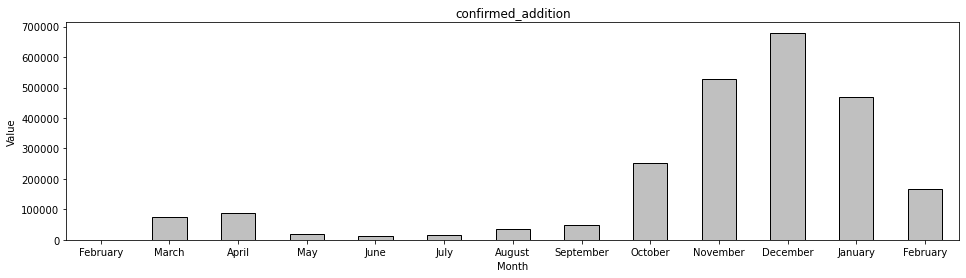

In [38]:
corona_total_bar_plot('confirmed_addition',right_one[1:])

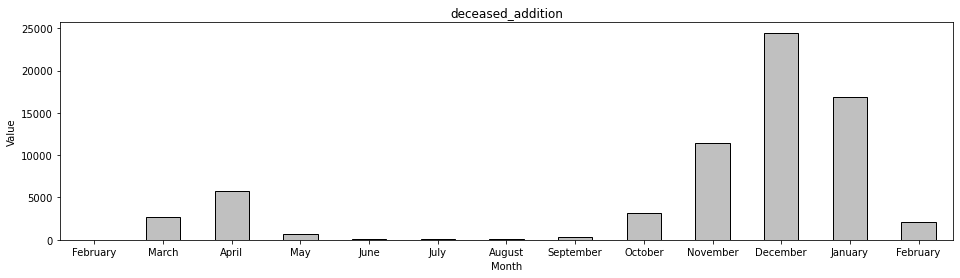

In [39]:
corona_total_bar_plot('deceased_addition',right_one[1:])

### Per Region

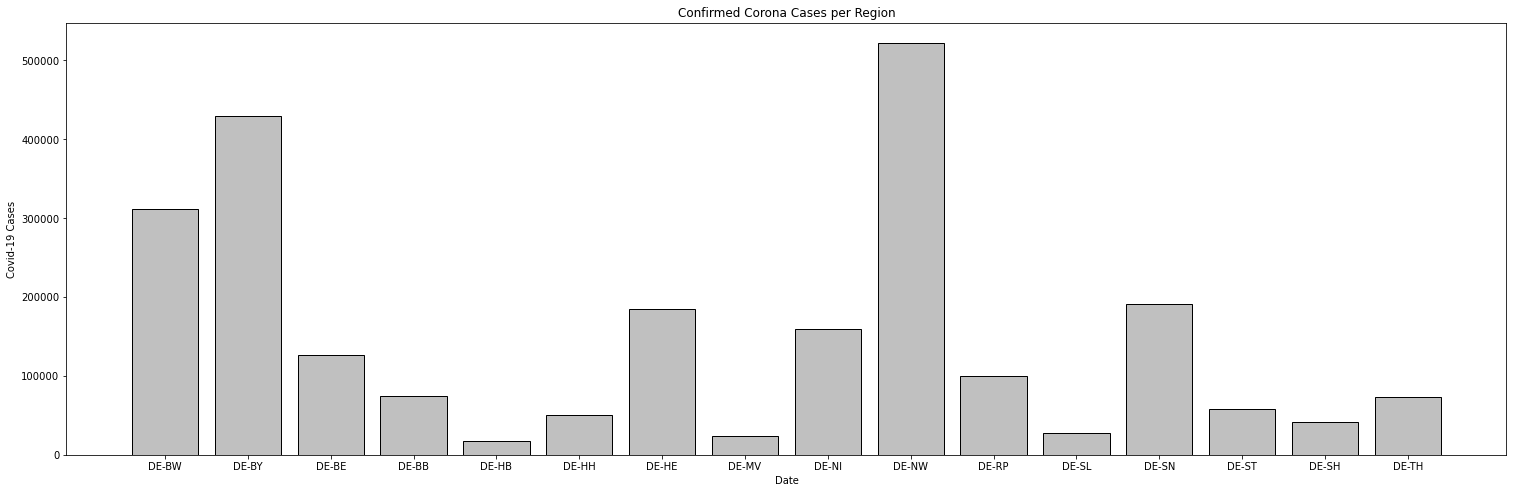

In [40]:
corona_bar_plot(corona_by_region['iso3166-2_code'],corona_by_region['confirmed_addition'],'Confirmed Corona Cases per Region') #potential use

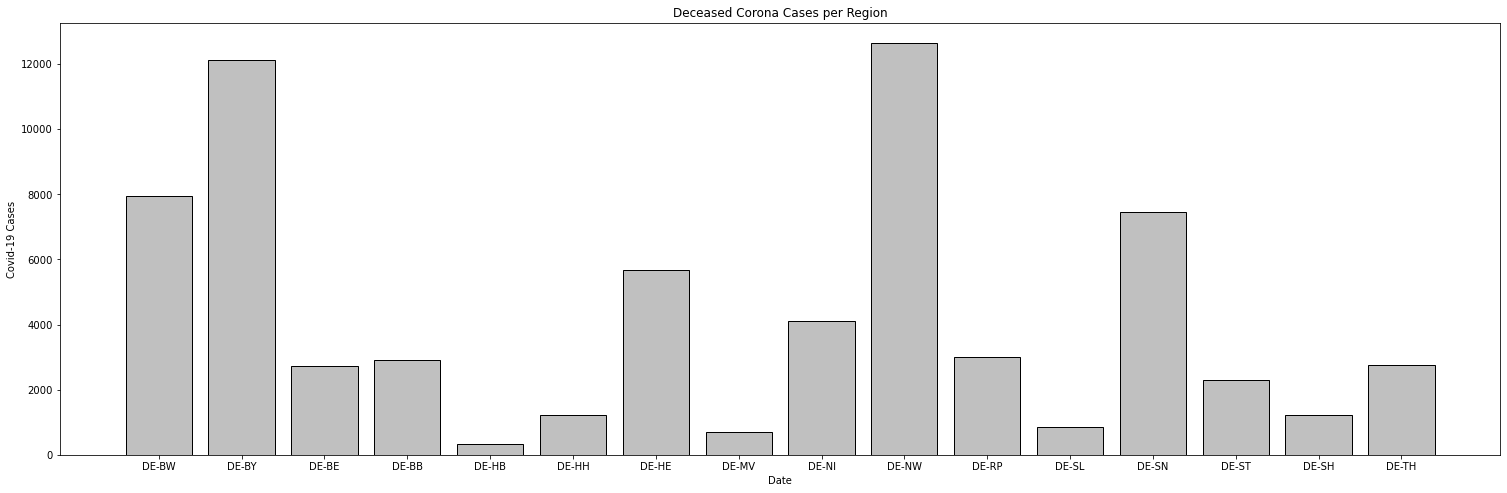

In [41]:
corona_bar_plot(corona_by_region['iso3166-2_code'],corona_by_region['deceased_addition'],'Deceased Corona Cases per Region') #potential use

## Weather

In [42]:
#weather_date = pd.to_datetime(weather_data_de['date'])
#weather_2020=pd.DataFrame(weather_data_de[weather_date.dt.year == 2020])
#weather_2021=pd.DataFrame(weather_data_de[weather_date.dt.year == 2021])

#weather_month_2020 = pd.DataFrame(weather_2020.groupby(weather_date.dt.month).mean())
#weather_month_2021 = pd.DataFrame(weather_2021.groupby(weather_date.dt.month).mean())
#right_weather_one = weather_month_2020.append(weather_month_2021)
#celsius = pd.DataFrame(weather_data_de['TemperatureAboveGround'].subtract(273.15))
#right_weather_one['Temp_Celsius'] = celsius
#right_weather_one

In [43]:
#grouping weather conditions per day
weather_date = pd.to_datetime(weather_data_de['date'])
weather_daily = pd.DataFrame(weather_data_de.groupby(weather_date).mean())
weather_daily

,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,Temp_Celsius
date,,,,,,,,
2020-02-13,83.550416,9.232296e+05,2.361713e+06,276.080346,5.424938e-03,3.045868,4.677214,2.930346
2020-02-14,87.038057,1.189954e+06,2.385722e+06,277.740734,1.314437e-03,1.875386,3.260335,4.590734
2020-02-15,78.429711,2.849352e+06,2.388378e+06,279.481576,1.507500e-04,3.958054,4.619486,6.331576
2020-02-16,63.587472,7.130768e+05,2.360307e+06,284.575068,4.384375e-03,3.224329,7.988258,11.425068
2020-02-17,73.292063,1.628548e+06,2.373769e+06,280.940914,3.835563e-03,3.951442,6.621854,7.790914
...,...,...,...,...,...,...,...,...
2021-02-17,88.572442,1.161559e+06,2.382257e+06,278.646276,1.361375e-03,2.553174,4.053323,5.496276
2021-02-18,81.035245,2.263309e+06,2.377988e+06,279.161078,2.961500e-03,4.127690,3.631289,6.011078
2021-02-19,80.723951,4.444755e+06,2.384026e+06,278.902828,9.605000e-04,4.426027,3.576306,5.752828


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


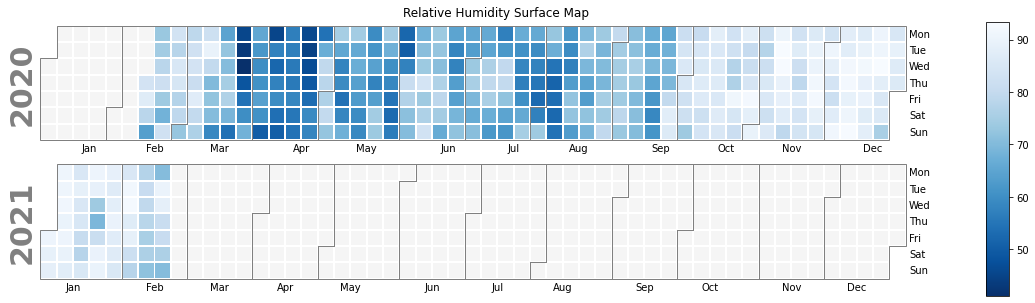

In [44]:
heat_calendar(weather_daily,'RelativeHumiditySurface','Blues_r','Relative Humidity Surface Map');

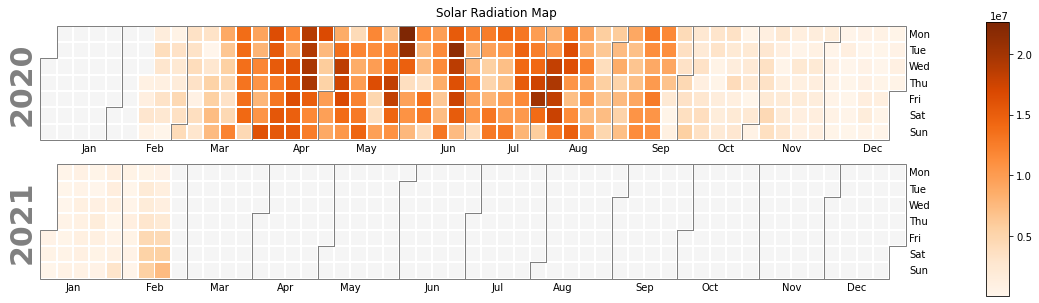

In [45]:
heat_calendar(weather_daily,'SolarRadiation','Oranges','Solar Radiation Map');

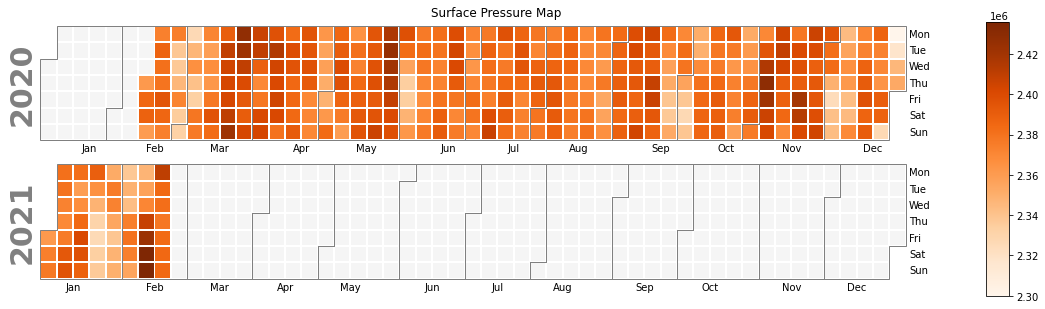

In [46]:
heat_calendar(weather_daily,'Surfacepressure','Oranges','Surface Pressure Map');

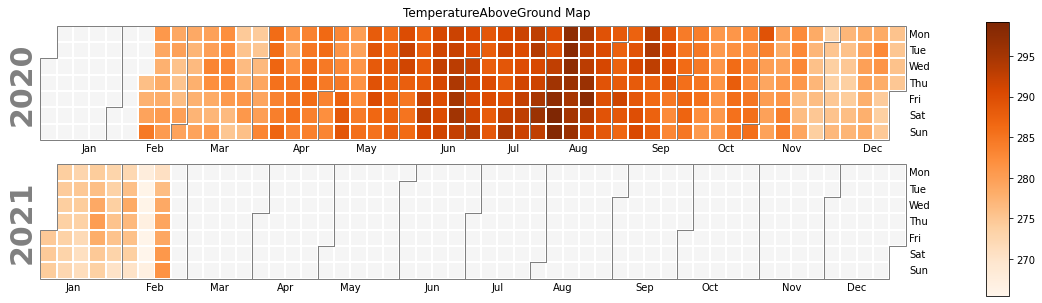

In [47]:
heat_calendar(weather_daily,'TemperatureAboveGround','Oranges','TemperatureAboveGround Map');

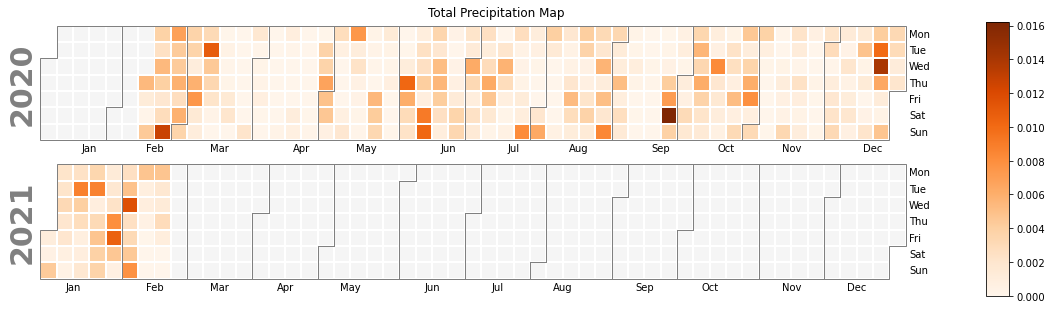

In [48]:
heat_calendar(weather_daily,'Totalprecipitation','Oranges','Total Precipitation Map');

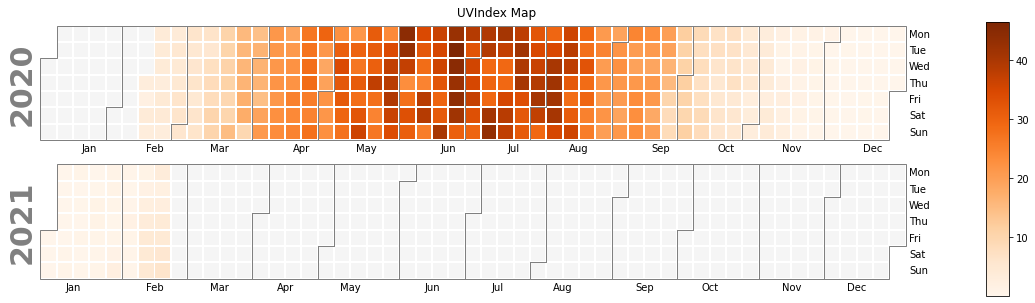

In [49]:
#description
heat_calendar(weather_daily,'UVIndex','Oranges','UVIndex Map');

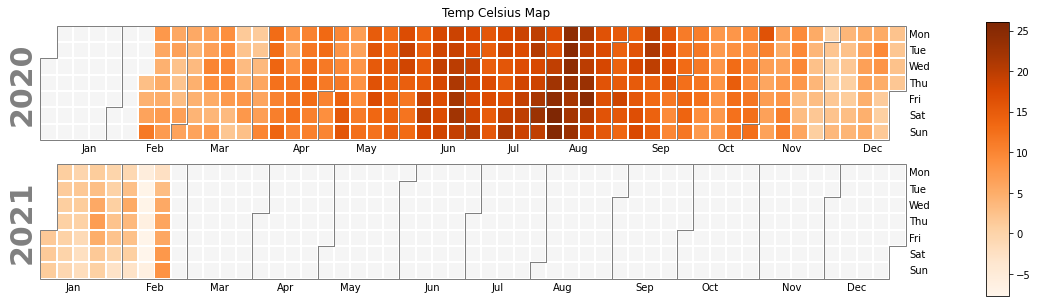

In [50]:
heat_calendar(weather_daily,'Temp_Celsius','Oranges','Temp Celsius Map');

# Task 2 - Associations

## Daily Associations

In [51]:
weather_headers = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed','Temp_Celsius']
significance_threshold = 0.001 / (len(weather_headers) * 3)

### Pearson association for daily_corona_weather for original dataset

Testing for linearity in the data

In [74]:
pearson_association(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

RelativeHumiditySurface 
 0.34264     1.6645350728481603e-153 True 

SolarRadiation 
 -0.34636     4.9463537017058293e-157 True 

Surfacepressure 
 -0.25441     3.724268829474388e-83 True 

TemperatureAboveGround 
 -0.36396     2.2266597734583237e-174 True 

Totalprecipitation 
 0.04607     0.0005757858841694551 False 

UVIndex 
 -0.42445     6.229321949127303e-243 True 

WindSpeed 
 -0.03342     0.0125469030820965 False 

Temp_Celsius 
 -0.36396     2.2266597734583237e-174 True 



KeyError: 'const'

Visualizing the pearson correlation

In [ ]:
sns.regplot(x="confirmed_addition", y="Temp_Celsius", data=daily_corona_weather, color="black", ci=None,line_kws={'lw':4})

In [ ]:
sns.regplot(x="confirmed_addition", y="UVIndex", data=daily_corona_weather, color="black", ci=None, line_kws={'lw':4})

### Spearman association for daily_corona_weather for original dataset.

In [69]:
#spearman_association(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

RelativeHumiditySurface 
 0.46803     7.510592264687037e-302 True 

SolarRadiation 
 -0.51605     0.0 True 

Surfacepressure 
 -0.23857     4.681330884969123e-73 True 

TemperatureAboveGround 
 -0.57797     0.0 True 

Totalprecipitation 
 0.07239     6.176316724575035e-08 True 

UVIndex 
 -0.65459     0.0 True 

WindSpeed 
 -0.01401     0.29525564389645925 False 

Temp_Celsius 
 -0.57797     0.0 True 



Testing for monotonic relationships in the data

### Pearson asscociation for daily_corona_weather, with logtransformation of confirmed_addition

In [68]:
#pearson_log(daily_corona_weather,'confirmed_addition',weather_headers,significance_threshold)

### Associations for the deceased_addition

In [70]:
#pearson_association(daily_corona_weather,'deceased_addition',weather_headers,significance_threshold)

In [59]:
spearman_association(daily_corona_weather,'deceased_addition',weather_headers,significance_threshold)

RelativeHumiditySurface 
 0.39763     9.261049010143888e-211 True 

SolarRadiation 
 -0.46224     1.613376804147463e-293 True 

Surfacepressure 
 -0.20186     2.1516133275312377e-52 True 

TemperatureAboveGround 
 -0.62728     0.0 True 

Totalprecipitation 
 0.04083     0.0022821199452935604 False 

UVIndex 
 -0.63257     0.0 True 

WindSpeed 
 0.03843     0.004086210455727461 False 

Temp_Celsius 
 -0.62728     0.0 True 



In [65]:
#pearson_log(daily_corona_weather[2:],'deceased_addition',weather_headers,significance_threshold) #can't be done because of zeros

Testing if there is a linear relationship on a non-linear scale in the data and if the data is skewed, thus a log transformation is used.


### sm.ols (Least Squares) multivariate regression


Values here may be misleading. This is because the multivariate regression, when looking at specific variables, it keeps all the other variables constant.

In [72]:
df = sm.add_constant(daily_corona_weather)
weather_headers.extend(["const"])

In [73]:
est = sm.OLS(df["confirmed_addition"], df[weather_headers], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     283.5
Date:                Wed, 17 Mar 2021   Prob (F-statistic):               0.00
Time:                        16:22:31   Log-Likelihood:                -44588.
No. Observations:                5580   AIC:                         8.919e+04
Df Residuals:                    5572   BIC:                         8.925e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

Here TemperatureAboveGround is a misleading variable, since in the previous sections we analysed that having a higher temperature leads to fewer cases. Though in this multiplevariate regression it is found out that a higher temperature increases the number of cases, this contradicts all prior analysis. The reason for this is that the multivariate regression keeps all other variables constant. That is, a day with the exact same weather conditions, besides the temperature being higher, will lead to more cases. To this there could be multiple reasons for this to occur, though a major and probable reason could be that people go outside during high temperatures, which in turn will lead to people not being isolated and thus there will be a higher probability of people getting a Covid-19 infection. 

Thus all these weather variables lead to change in human behavior, which results in changes in the amount of Covid-19 cases.

In [ ]:
est = sm.OLS(df["deceased_addition"], df[weather_headers], hasconst = True).fit()
print(est.summary())

All the weather variables does not result in anything interesting to be discorvered. From the multivariate regression it is apparent that more people die, with a covid-19 infection, during higher solar radiation. It also shows that fewer people die when the total precipitation is higher. Intuitively these variables does change the human behavior, but in no way that would cause them to reduce or increase the number of deaths caused by covid-19. Also the people dying of Covid-19 is most likely in a hospital bed and is under extensive care, thus intuitively these weather variables would not lead to changes in covid-19 deaths. 

The only explanation would be that the hospital care is worsened during good weather and better during poor weather. Which also does not make much sense intuitively.

In [ ]:
#corona and weather conditions grouped by months
weather_date = pd.to_datetime(weather_data_de['date'])
weather_2020=pd.DataFrame(weather_data_de[weather_date.dt.year == 2020])
weather_month_2020 = pd.DataFrame(weather_2020.groupby(weather_date.dt.month).mean())
df_monthly_sum = corona_month_sum.merge(weather_month_2020,left_on = 'date',right_on = 'date')

In [ ]:
weather_headers_month = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed']
significance_threshold_monthly = 0.5 / (len(weather_headers_month) * 3)
print(significance_threshold_monthly)

Here the significance threshhold is increased due to the grouping of the data into months. This means that the breakpoint of where a variable is as not being correlated by chance is higher, which means that the certainty that the variable is a correlated by chance is less precise. 

#### Corona Cases per Month

In [ ]:
pearson_association(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

In [ ]:
#a scatterplot of two variables, x and y, 
#regression line - fit a line to the data by calculating R^2 (sum of least squares)
fig, ax = plt.subplots()
ax2 = ax.twinx() #This allows the common axes (flow rate) to be shared
sns.regplot(x="confirmed_addition", y="RelativeHumiditySurface", data=df_monthly_sum, ax=ax, color="black", ci=None,line_kws={'lw':4})
sns.regplot(x="confirmed_addition", y="UVIndex", data=df_monthly_sum, color="gray", ax=ax2, ci=None, line_kws={'lw':4})

ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], 
           labels=["Temp_Celsius", "UVIndex"])
plt.show()

In [ ]:
spearman_association(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

In [ ]:
pearson_log(df_monthly_sum,'confirmed_addition',weather_headers_month,significance_threshold_monthly)

From these multivariate regressions it is apparent from the pearson that there is a correlation between the monthly total of Covid-19 cases and RelativeHumiditySurface, SolarRadiation and UVIndex. These variables tend to be higher during the summer, where there was a decrease in Covid-19 cases, thus this makes sense. Though in the spearman there is also seen high correlations, though the p-value is too high for us to assume that it has not happend by chance.

#### Corona Deaths per Month

In [ ]:
pearson_association(df_monthly_sum,'deceased_addition',weather_headers_month,significance_threshold_monthly)

In [ ]:
spearman_association(df_monthly_sum,'deceased_addition',weather_headers_month,significance_threshold_monthly)

In [ ]:
pearson_log(df_monthly_sum[1:],'deceased_addition',weather_headers_month,significance_threshold_monthly) #interesting, check temperature above ground

The analysis of the corona cases/deaths per month could be interesting when it is analyzed how infectious one strain is from another. This would be quite hard to do daily because there is really hard that 1st of February 2020 would have the same weather conditions as 1st of February 2021. Therefore, there is a higher chance that the overall weather conditions in February 2020 to be the similar to February 2021.

### Dummy Variable Analysis

In [ ]:
daily_corona_weather['Lockdown'] = '0'
daily_corona_weather.loc[(daily_corona_weather["date"] >= "2020-11-02") & (daily_corona_weather["date"] <= "2021-03-07"), "Lockdown"] = '1'
daily_corona_weather

In [ ]:
mask = (corona_df['date'] > "2020-11-02") & (corona_df['date'] <= "2021-03-07")
corona_daily_sum = corona_df.groupby(corona_df['date']).sum().reset_index()
corona_daily_sum_lockdown = corona_df[mask].groupby(corona_df[mask]['date']).sum().reset_index()
#corona_daily_sum_lockdown

In [ ]:
corona_line_plot(corona_daily_sum,'date','confirmed_addition','Corona lockdown plot')

In [ ]:
corona_line_plot(corona_daily_sum,'date','deceased_addition','Corona lockdown plot')

Data taken from https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Germany - Government Reactions

- 15th March, borders to Austria, Denmark, France, Luxembourg and Switzerland were closed (light-red)
- 22nd March, curfews were imposed in six German states while other states prohibited physical contact with more than one person from outside one's household. (dark-red)
- 15th April loosening of restrictions (blue)
- 2nd November a partial lockdown was implemented, in which physical distancing rules were tightened while schools and kindergartens remained open, only temporarily halted the rise in case numbers (light-red)
- 15th December a hard lockdown was implemented (dark-red)
- 26th December 2020 - Vaccinations with the BioNTech–Pfizer COVID-19 vaccine began  (green)

In [ ]:
corona_bar_plot(corona_daily_sum_lockdown['date'],corona_daily_sum_lockdown['confirmed_addition'],'Corona Lockdown Cases')

In [ ]:
corona_bar_plot(corona_daily_sum_lockdown['date'],corona_daily_sum_lockdown['deceased_addition'],'Corona lockdown plot')

In [ ]:
x = ['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'TemperatureAboveGround',
             'Totalprecipitation', 'UVIndex', 'WindSpeed','Lockdown','const']
df1 = sm.add_constant(daily_corona_weather)
est1 = sm.OLS(np.log(df1['confirmed_addition']), df1[x].astype(float), hasconst = True).fit()
print(est1.summary())

# Task 3 - Map visualization

In [ ]:
corona_by_region

## Total number of Cases of Covid-19 on a regional basis

In [ ]:
n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = corona_by_region,
    columns = ["iso3166-2_code", "confirmed_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Number of Cases of Covid-19").add_to(n_cases)
n_cases

## Total number of deceased with a confirmed Covid-19 infection on a regional basis


In [ ]:
dead = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = corona_by_region,
    columns = ["iso3166-2_code", "deceased_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "Greys", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Number of Deceased with an covid-19 infection").add_to(dead)
dead

## Population on a regional basis 

In [ ]:
p_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
folium.Choropleth(
    geo_data = shape,
    name = "population",
    data = corona_by_region,
    columns = ["iso3166-2_code", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "YlGn", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "Population").add_to(p_cases)
p_cases

## Number of Cases pr. population of region

In [ ]:
r_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

tiles = ['stamenwatercolor', 'cartodbpositron', 'openstreetmap', 'stamenterrain']
for tile in tiles:
    folium.TileLayer(tile).add_to(r_cases)

folium.Choropleth(
    geo_data = shape,
    name = "cases",
    data = corona_by_region,
    columns = ["iso3166-2_code", "confirmed/pop"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases pr. population of region",
    highlight=True
).add_to(r_cases)

folium.LayerControl().add_to(r_cases)

r_cases

## UVIndex on a regional basis

The UVIndex is a daily sum, this is handled by dividing by 24, because there is 24 hours in a day. This will though result in very small UVIndex values, because UVIndex during the night is taken into account.

In [ ]:
# dividing by 24 since there is 24 hours in a day, though this takes into account night where the uvindex is 
# really small/nonexsistent
# Could be argued that it should be divided by 16-18 since these are the hours where the sun is present. 
weather_by_region = pd.DataFrame(weather_data_de.groupby(by = 'iso3166-2').mean())
weather_by_region['UVIndex_scaled'] = weather_by_region['UVIndex']/24

In [ ]:
uv_index = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "uv-index",
    data = weather_by_region,
    columns = [weather_by_region.index, "UVIndex_scaled"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "UVIndex",
    smooth_factor=0).add_to(uv_index)
uv_index

## Temperature Above Ground on a regional basis

The Temperature Above Ground is a daily sum, this means that the data is flawed and is a lot higher than expected. This is handled by dividing by 24, because there is 24 hours in a day. This will though result in very small temperature values, because the temperature during the night is taken into account. Considering the flaws here this is still a more accurate measure then what the original data would have been. 

In [ ]:
weather_by_region["TemperatureAboveGround_scaled"] = weather_by_region["TemperatureAboveGround"]/24

In [ ]:
TAG = folium.Map(location = [51.5, 10.7], zoom_start = 6)

folium.Choropleth(
    geo_data = shape,
    name = "uv-index",
    data = weather_by_region,
    columns = [weather_by_region.index, "TemperatureAboveGround_scaled"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd", 
    fill_opacity = 0.7,
    line_opacity = 0.2,
    highlight=True,
    legend_name = "average Temperature Above Ground on a daily basis").add_to(TAG)
TAG

## Multiple plots on a regional and monthy basis

In [ ]:
raw_data['de_corona']['month'] = raw_data['de_corona']['date'].dt.strftime('%B')
raw_data['de_corona']['year'] = raw_data['de_corona']['date'].dt.strftime('%Y')
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"] for i in range(len(country_metadata["country_metadata"]))}
raw_data["de_corona"]["population"] = raw_data["de_corona"]["region"].map(population_map)
raw_data["de_corona"]["confirmed_addition_ratio"] = raw_data["de_corona"]["confirmed_addition"]/raw_data["de_corona"]["population"]

In [ ]:
cases_2020_monthly = raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")].groupby(["month", "region"]).sum()
cases_2021_monthly = raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")].groupby(["month", "region"]).sum()

In [ ]:
confirmed_addition_ratio_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
    
    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition_ratio"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 pr. population of region in {} 2020".format(i)).add_to(n_cases)
    confirmed_addition_ratio_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition_ratio"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 pr. population of region in {} 2021".format(i)).add_to(n_cases)
    confirmed_addition_ratio_maps[i+"-2021"] = n_cases    

In [ ]:
confirmed_addition_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)
    
    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2020</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 in {} 2020".format(i)).add_to(n_cases)
    confirmed_addition_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2021</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "confirmed_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "OrRd", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of Cases of Covid-19 in {} 2021".format(i)).add_to(n_cases)
    confirmed_addition_maps[i+"-2021"] = n_cases   
confirmed_addition = ["other_notebooks/maps/confirmed_addition/"+i+".png" for i in confirmed_addition_maps.keys()]
images = []
for filename in confirmed_addition:
    images.append(imageio.imread(filename))
imageio.mimsave('other_notebooks/map_gifs/confirmed_addition_maps.gif', images, duration=2)

In [ ]:
deceased_addition_maps = dict()
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2020")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2020</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2020_monthly.loc[i].reset_index(),
        columns = ["region", "deceased_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "Greys", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of deceased with a Covid-19 infection in {} 2020".format(i)).add_to(n_cases)
    deceased_addition_maps[i+"-2020"] = n_cases
for i in list(raw_data["de_corona"][(raw_data["de_corona"]["year"] == "2021")]["month"].unique()):
    n_cases = folium.Map(location = [51.5, 10.7], zoom_start = 6)

    folium.map.Marker(
    [54.5, 2],
    icon=DivIcon(
        icon_size=(400,50),
        icon_anchor=(0,0),
        html='<div style="font-size: 20pt">{}-2021</div>'.format(i),
        )
    ).add_to(n_cases)
    
    folium.Choropleth(
        geo_data = shape,
        name = "cases",
        data = cases_2021_monthly.loc[i].reset_index(),
        columns = ["region", "deceased_addition"],
        key_on = "properties.iso_3166_2",
        fill_color = "Greys", 
        fill_opacity = 0.7,
        line_opacity = 0.2,
        highlight=True,
        nan_fill_color = "purple",
        legend_name = "Number of deceased with a Covid-19 infection in {} 2021".format(i)).add_to(n_cases)
    deceased_addition_maps[i+"-2021"] = n_cases   
deceased_addition = ["other_notebooks/maps/deceased_addition/"+i+".png" for i in confirmed_addition_maps.keys()]
images = []
for filename in deceased_addition:
    images.append(imageio.imread(filename))
imageio.mimsave('other_notebooks/map_gifs/deceased_addition_maps.gif', images, duration=2)

### Viewing the maps

All the monthly maps can be ascessed by doing 
```python
deceased_addition_maps["January-2020"]
confirmed_addition_maps["January-2020"]
confirmed_addition_ratio_maps["January-2020"]
```
Missing data, or there was no recorded data in that region, the color of the region will be purple

Month and year can be changed

In [ ]:
confirmed_addition_maps["January-2020"]

![SegmentLocal](other_notebooks/map_gifs/confirmed_addition_maps.gif)

In [ ]:
deceased_addition_maps["January-2020"]

![SegmentLocal](other_notebooks/map_gifs/deceased_addition_maps.gif)

In [ ]:
confirmed_addition_ratio_maps["January-2020"]

##  Task 4: Open question
Use the data to formulate, motivate, answer, and discuss another research question of your choice. For example, compare your country to another one in the dataset; or investigate additional variables that you could
find elsewhere (e.g. total population, population density, population demographics such as age distribution,
number of elders, etc); or identify if there are temporal patterns (is one variable more important in some
months? Are weekends different from weekdays? Etc), ..

##### We loaded an external data set from the website of 'Robert Koch Institut' (RKI) to explore the role of age in potentially driving differences in infection spread.
The data set is about  COVID-19 cases by age group / 100,000 inhabitants in Germany from the 17th of March 2020 to the 2nd of March 2021.  
https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Daten/Altersverteilung.html

#### The weekly mean of total confirmed cases per 100.000 inhabitants across age groups
We added the mean of the weekly cases by age to the table to get a quick insight into the age distribution.

In [ ]:
raw_data['age_pop']['mean'] = raw_data['age_pop'].mean(axis=1)
raw_data['age_pop']

In [ ]:
raw_data['age_pop']['mean'].describe()

#### Visualize distribution of weekly mean of total confirmed cases per 100.000 per age

In [ ]:
rcParams['figure.figsize'] = 15,8
sns.set_style("whitegrid");

In [ ]:
ax = sns.barplot(x="mean", y="Altersgruppe", data=raw_data['age_pop']).set_title('The weekly mean of total confirmed cases per 100.000 people across age groups')

The weekly registered infections among people above 90 is extremely higher than other age groups. 

The reason seems not to be the population size of each group. (RKI: 40-59-year-olds make up the largest age group in Germany, at 23.6 million people, the next-largest age group was 65 years and older, at 18.09 million.)

#### Temporal distribution of cases across age groups

In [ ]:
df_T = raw_data['age_pop'].T
modified = df_T.reset_index()
new_header = modified.iloc[0] #grab the first row for the header
modified = modified[1:] #take the data less the header row
modified.columns = new_header #set the header row as the df header
modified.rename(columns={"Altersgruppe":"date"}, inplace=True)
modified = modified.drop([53])
modified['date'] = modified['date'].astype(str) + '_2' #2 means Tuesday
modified['date'] =  pd.to_datetime(modified['date'], format='%Y_%W_%w')

for column in modified:
    modified.iloc[:, 1:21] = modified.iloc[:, 1:21].astype(float)

# merge age groups
modified['0-19'] = modified.loc[:,['0 - 4','5 - 9', '10 - 14', '15 - 19']].sum(axis=1)
modified['20-39'] = modified.loc[:,['20 - 24','25 - 29', '30 - 34', '35 - 39']].sum(axis=1)
modified['40-59'] = modified.loc[:,['40 - 44', '45 - 49', '50 - 54', '55 - 59']].sum(axis=1)
modified['60-79'] = modified.loc[:,['60 - 64','65 - 69', '70 - 74', '75 - 79']].sum(axis=1)
modified['80+'] = modified.loc[:,['80 - 84', '85 - 89', '90+']].sum(axis=1)
#modified

The pandemic is exhibiting seasonal patterns in its spread. It is clear that there is a peak in the number of cases in the winter period of 2020-2021 and the number of cases are low during the summer of 2020. 
Next, the distribution of these specific periods will be plotted by ages.

In [ ]:
x = modified.drop(modified.columns.difference(['date', '0-19', '20-39', '40-59', '60-79', '80+']), axis=1)
melt_modified = x.melt('date', var_name='age_gaps',  value_name='cases')

g = sns.lineplot(x="date", y="cases", hue='age_gaps', data=melt_modified).set_title('All weekly registered cases in Germany by age groups')

In [ ]:
mask_winter = (melt_modified['date'].dt.month > 10)
winter = melt_modified[mask_winter]

g = sns.lineplot(x="date", y="cases", hue='age_gaps', data=winter).set_title('2020-2021: WINTER: All weekly registered cases in Germany by age groups');

In [ ]:
mask_summer = ((melt_modified['date'].dt.month < 9) & (melt_modified['date'].dt.month > 5))
summer = melt_modified[mask_summer]

g = sns.lineplot(x="date", y="cases", hue='age_gaps', data=summer).set_title('2020 SUMMER: All weekly registered cases in Germany by age groups');

However, in summer time, when the number of all cases are low, the proportion of the infected among young adults are higher, among the age group 20-39 the highest.

By investigating the possible connections between the weather variables and the number of cases by age groups, the focus will be on the two most interesting ones that are not following the pattern: people from 20 to 39 years and above 80.

In [ ]:
#merge corona_age & weather WEEKLY for plots
#corona age: 2020.03.12 - 2021.03.02.  - weather: 2020-02-13 - 2020.11.14.

#prepare weather data to merge without regions
df_w = weather_data_de.copy()
#sum some weather values:
df_w_sum = df_w.groupby('date')['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'Totalprecipitation'].sum()
#take the mean some weather values:
df_w_mean = df_w.groupby('date')['TemperatureAboveGround', 'UVIndex', 'WindSpeed'].mean()
df_w_noregions = df_w_sum.merge(df_w_mean, left_on = ["date"], right_on = ["date"]) 
#date index to column data:
df_w_noregions.reset_index(level=0, inplace=True)

#merge (modified is the weekly corona data by age)
weekly_coronaAge_weather = modified.merge(df_w_noregions, left_on = ["date"], right_on = ["date"])
weekly_coronaAge_weather.drop_duplicates(subset='date');

celsius = pd.DataFrame(weekly_coronaAge_weather['TemperatureAboveGround'].subtract(273.15))
weekly_coronaAge_weather['Temp_Celsius'] = celsius

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot(x="80+", y="Temp_Celsius", data=weekly_coronaAge_weather, ax=ax1, color="black", ci=None)
sns.regplot(x="20-39", y="Temp_Celsius", data=weekly_coronaAge_weather, ax=ax2, color="black", ci=None);

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
sns.regplot(x="80+", y="UVIndex", data=weekly_coronaAge_weather, ax=ax1, color="black", ci=None)
sns.regplot(x="20-39", y="UVIndex", data=weekly_coronaAge_weather, ax=ax2, color="black", ci=None);

### Multivariate linear regression using statsmodel for daily_coronaAge_weather 80+

Are there any differencies how the different weather variables can influence the number of cases by that two specific age groups? 

In [ ]:
#DAILY DATA
#There is data for 52 weeks: create daily data - divide the case numbers by 7
modified['date'] = pd.to_datetime(modified['date'])
daily_age = modified.set_index('date').resample('d').mean().ffill().div(7).reset_index()


#changes in weather data: change values: sum and mean
#df_w = de_weather.copy()
#df_w_sum = df_w.groupby('date')['RelativeHumiditySurface', 'SolarRadiation', 'Surfacepressure', 'Totalprecipitation'].sum()
#df_w_mean = df_w.groupby('date')['TemperatureAboveGround', 'UVIndex', 'WindSpeed'].mean()
#no need for regions
df_w_noregions = df_w_sum.merge(df_w_mean, left_on = ["date"], right_on = ["date"]) 
daily_coronaAge_weather = daily_age.merge(df_w_noregions,  left_on = ["date"], right_on = ["date"])
daily_coronaAge_weather = daily_coronaAge_weather.drop_duplicates(subset='date')

celsius = pd.DataFrame(daily_coronaAge_weather['TemperatureAboveGround'].subtract(273.15))
daily_coronaAge_weather['Temp_Celsius'] = celsius
#daily_age
#daily_coronaAge_weather

In [ ]:
daily_coronaAge_weather = sm.add_constant(daily_coronaAge_weather)

est = sm.OLS(np.log(daily_coronaAge_weather['80+']), daily_coronaAge_weather[weather_headers], hasconst = True).fit()
print(est.summary())

### Multivariate linear regression using statsmodel for daily_coronaAge_weather 20-39

In [ ]:
est = sm.OLS(np.log(daily_coronaAge_weather['20-39']), daily_coronaAge_weather[weather_headers], hasconst = True).fit()
print(est.summary())

R-squared 0.760 and 0.882 (corr.coeff. squared) It means this model can explain the 76% and 82.2% of the variation in our data. 
Comparing the two multivariable linear regression model results shows that from the 7 weather variables, 6 has corresponding associations with the numbers of cases, only the temperature above ground variable shows a difference. At the age group 20-39 it is positive(0.0087),  at people above 80 is negative(-0.1188)

While analyzing how the COVID-19 infection spread across different age groups, the most conspicuous patterns in the temporal data distribution were that COVID-19 cases are highest in young adults in summer and extremely higher in people above 80 in winter. 
With a linear regression model, we only could underline this fact.
Intuitively when the numbers of covid cases are low and the weather is fine, young adults, who are not the most endangered age group, are more likely to take risks against social distancing. 
The possible explanation can be for higher infection rates across people above 80, that they are biologically the most susceptible population for covid-19.
